# Лабораторная работа №8. Сверточные нейронные сети (CNN). Компьютерное зрение. Задача классификации изображений

**ЗАДАНИЕ №1.**
1. Загрузите датасет для классификации кошек и собак: https://drive.google.com/file/d/1YQ2PX-BZ_7uZ216qmAnx-nTCaEqozuCZ/view?usp=share_link.
2. Выполните как минимум две аугментации.
3. Соберите CNN с помощью фреймворка Tensorflow и решите задачу классификации кошек и собак. Выполните оценку модели.
4. Сформулируйте вывод на основе ответов следующих вопросов:
- Какие этапы предварительной обработки данных Вы делаете и что происходит с данными?
- Что означают параметры, которые Вы задаете?
- Какие слои есть в Вашей реализации CNN и что происходит на каждом слое?


**ЗАДАНИЕ №2.**
1. Загрузите датасет с множеством различных классов: https://data.caltech.edu/records/mzrjq-6wc02/files/caltech-101.zip. Выберите 3 любых класса, которые Вам нравятся. Загрузите данные и сформируете датасет.
2. Выполните как минимум две аугментации.
3. С помощью фреймворка Tensorflow загрузите модели InceptionV3 и VGG19. Выполните Transfer Learning и Fine-Tuning этих моделей для распознавания классов. В процессе подготовки CNN, разморозьте какой-либо еще слой, кроме последнего. Сравните результаты двух моделей CNN на Ваших данных (по метрике accuracy в процессе обучения).
4. Реализуйте сверточный слой (прямое и обратное распространение). Используйте реализацию многослойного персептрона из ЛР №7. Соберите CNN, используя разработанные Вами слои.
5. Попробуйте обучить классификатор кошек и собак с использованием собственной реализации CNN.


*ЗАДАНИЕ №3***
Реализуйте слои MaxPooling, AveragePooling и MinPooling (прямое и обратное распространение). Самостоятельно найдите схему вычисления градиента.

In [3]:
import tensorflow as tf
import numpy as np
from tensorflow import keras

## Задание № 1

### Загрузка датасета для классификации кошек и собак

In [71]:
train_ds, test_ds = keras.utils.image_dataset_from_directory(
    '../../../Jupyter Notebook/data/data3', # путь к изображениям
    validation_split=0.2, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(200,400), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 2000 files belonging to 2 classes.
Using 1600 files for training.
Using 400 files for validation.


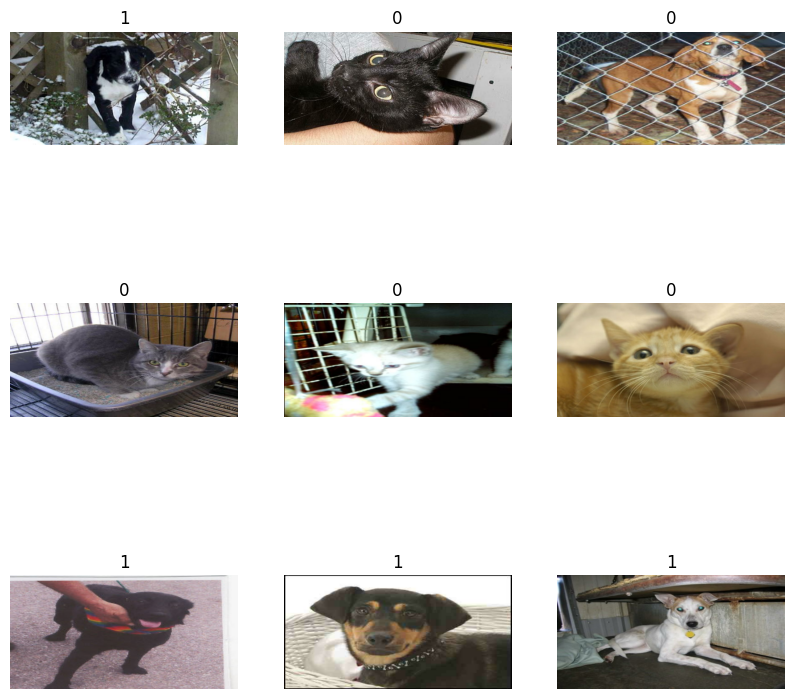

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

### Применение аугментаций к данным

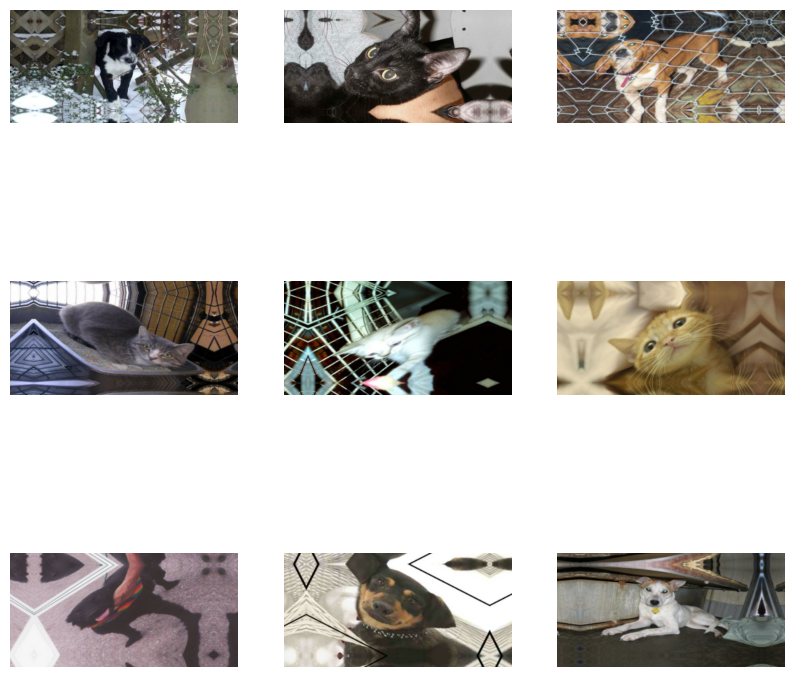

In [72]:
from keras.layers import RandomFlip, RandomRotation, RandomZoom

data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(height_factor=(0.2, 0.3))
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

Нормально жмыхнуло!

In [73]:
# выполним аугментации для обучающих данных
train_ds = train_ds.map(
    lambda img, label: (data_augmentation(img), label)
)

In [74]:
# Входные данные
input_data = tf.random.normal([1, 7, 7, 1])  # (batch_size, height, width, channels)
filter_kernel = tf.random.normal([3, 3, 1, 1])  # (kernel_height, kernel_width, input_channels, output_channels)

# Padding и Stride
padding = 'SAME'
stride = [2, 2]

# Применение кросс-орреляции с указанием padding и stride
output = tf.nn.conv2d(input_data, filter_kernel, strides=stride, padding=padding)

print(output)

tf.Tensor(
[[[[ 0.4521947 ]
   [-0.34569797]
   [ 3.8099034 ]
   [-0.2737156 ]]

  [[ 3.8051734 ]
   [ 2.2849822 ]
   [-4.579192  ]
   [ 0.42884332]]

  [[-3.334076  ]
   [ 7.147448  ]
   [-0.42464098]
   [ 0.9830366 ]]

  [[-0.8766921 ]
   [-0.6450843 ]
   [-0.3163979 ]
   [ 0.82865304]]]], shape=(1, 4, 4, 1), dtype=float32)


### Сборка CNN с помощью фреймворка Tensorflow для задачи классификации кошек и собак. Оценка модели.

Для начала возьмем ту, которая была использована в примерах

In [75]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)
# первый сверточный слой
x = tf.keras.layers.Conv2D(64, 3, strides=2, padding="same")(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# второй сверточный слой
x = tf.keras.layers.Conv2D(128, 4, strides=2, padding="same")(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(3, strides=2, padding="same")(x)
# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)
# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(64, activation="relu")(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling_3 (Rescaling)     (None, 200, 400, 3)       0         
                                                                 
 conv2d_7 (Conv2D)           (None, 100, 200, 64)      1792      
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 50, 100, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_8 (Conv2D)           (None, 25, 50, 128)       131200    
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 13, 25, 128)       0         
 g2D)                                                      

In [76]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["accuracy"])

model.fit(train_ds, epochs=15, validation_data=test_ds)

Epoch 1/15
50/50 [==============================] - 24s 458ms/step - loss: 0.9663 - accuracy: 0.5150 - val_loss: 0.6689 - val_accuracy: 0.6225
Epoch 2/15
50/50 [==============================] - 25s 504ms/step - loss: 0.6774 - accuracy: 0.5694 - val_loss: 0.6695 - val_accuracy: 0.5675
Epoch 3/15
50/50 [==============================] - 24s 470ms/step - loss: 0.6650 - accuracy: 0.6006 - val_loss: 0.6317 - val_accuracy: 0.6425
Epoch 4/15
50/50 [==============================] - 24s 468ms/step - loss: 0.6601 - accuracy: 0.6112 - val_loss: 0.6169 - val_accuracy: 0.6375
Epoch 5/15
50/50 [==============================] - 47s 947ms/step - loss: 0.6355 - accuracy: 0.6475 - val_loss: 0.6078 - val_accuracy: 0.6400
Epoch 6/15
50/50 [==============================] - 26s 507ms/step - loss: 0.6412 - accuracy: 0.6363 - val_loss: 0.6245 - val_accuracy: 0.6475
Epoch 7/15
50/50 [==============================] - 39s 773ms/step - loss: 0.6183 - accuracy: 0.6737 - val_loss: 0.5745 - val_accuracy: 0.6825

Хотелось бы лучше точности ... Попробуем другую модель для распознавания кошек и собак

In [33]:
# входной слой - размер (200, 400, 3)
inputs = tf.keras.Input(shape=(200, 400, 3))
# преобразуем значения пикселей из [0, 255] к [0, 1]
x = tf.keras.layers.Rescaling(1.0 / 255)(inputs)

# первый сверточный слой
x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu', padding="valid")(x)
x = tf.keras.layers.BatchNormalization()(x)
# первый пулинг
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# второй сверточный слой
x = tf.keras.layers.Conv2D(64, (3, 3), activation='relu', padding="valid")(x)
x = tf.keras.layers.BatchNormalization()(x)
# второй пулинг
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# третий сверточный слой
x = tf.keras.layers.Conv2D(128, (3, 3), activation='relu', padding="valid")(x)
x = tf.keras.layers.BatchNormalization()(x)
# третий пулинг
x = tf.keras.layers.MaxPooling2D(pool_size=(2, 2))(x)
x = tf.keras.layers.Dropout(0.25)(x)

# выпрямляем многомерный массив
x = tf.keras.layers.Flatten()(x)

# полносвязный слой с 64 нейронами
x = tf.keras.layers.Dense(512, activation="relu")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Dropout(0.25)(x)
# выходной слой с функцией sofrmax
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)
model = tf.keras.Model(inputs, outputs)

model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 200, 400, 3)]     0         
                                                                 
 rescaling_1 (Rescaling)     (None, 200, 400, 3)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 198, 398, 32)      896       
                                                                 
 batch_normalization (Batch  (None, 198, 398, 32)      128       
 Normalization)                                                  
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 99, 199, 32)       0         
 g2D)                                                            
                                                                 
 dropout (Dropout)           (None, 99, 199, 32)       0   

In [37]:
model.compile(loss='sparse_categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20
50/50 [==============================] - 64s 1s/step - loss: 0.6369 - accuracy: 0.6719 - val_loss: 1.3348 - val_accuracy: 0.4700
Epoch 2/20
50/50 [==============================] - 63s 1s/step - loss: 0.6039 - accuracy: 0.7031 - val_loss: 1.3113 - val_accuracy: 0.4700
Epoch 3/20
50/50 [==============================] - 64s 1s/step - loss: 0.5726 - accuracy: 0.7075 - val_loss: 0.6950 - val_accuracy: 0.6075
Epoch 4/20
50/50 [==============================] - 64s 1s/step - loss: 0.5338 - accuracy: 0.7287 - val_loss: 0.9261 - val_accuracy: 0.5800
Epoch 5/20
50/50 [==============================] - 69s 1s/step - loss: 0.5289 - accuracy: 0.7569 - val_loss: 1.2258 - val_accuracy: 0.5350
Epoch 6/20
50/50 [==============================] - 62s 1s/step - loss: 0.5083 - accuracy: 0.7550 - val_loss: 0.5868 - val_accuracy: 0.6975
Epoch 7/20
50/50 [==============================] - 64s 1s/step - loss: 0.5069 - accuracy: 0.7556 - val_loss: 0.6348 - val_accuracy: 0.6850
Epoch 8/20
50/50 [==

1/1 [==============================] - 0s 52ms/step
[[0.0821168 0.9178832]]
Распознанный класс: 1


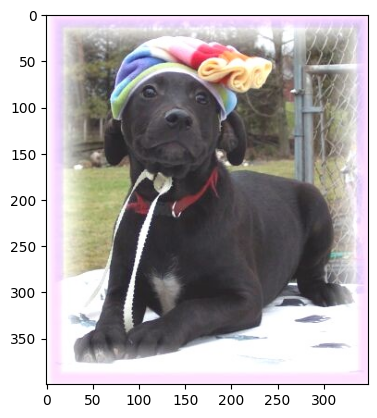

In [46]:
from PIL import Image
path = "../../../Jupyter Notebook/data/data3/dogs/138.jpg"

img = tf.keras.preprocessing.image.load_img(
    path, target_size=(200, 400)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))

Ура) Милый песик был распознан правильно!

## Задание № 2

### Загрузка датасета для классификации 3 классов (гарфилд, ноуты и морские звезды)

In [80]:
# формируем датасет
train_ds, test_ds = tf.keras.utils.image_dataset_from_directory(
    "../../../Jupyter Notebook/data/data4", # путь к изображениям
    validation_split=0.15, # процент на тест
    subset="both", # берем и обучающую и тестовую выборку
    seed=42, # сид генератора случайных чисел
    image_size=(224,224), # целевой размер изображения (СНАЧАЛА ВЫСОТА, ПОТОМ ШИРИНА)
    batch_size=32, # размер пакета (батча)
)

Found 201 files belonging to 3 classes.
Using 171 files for training.
Using 30 files for validation.


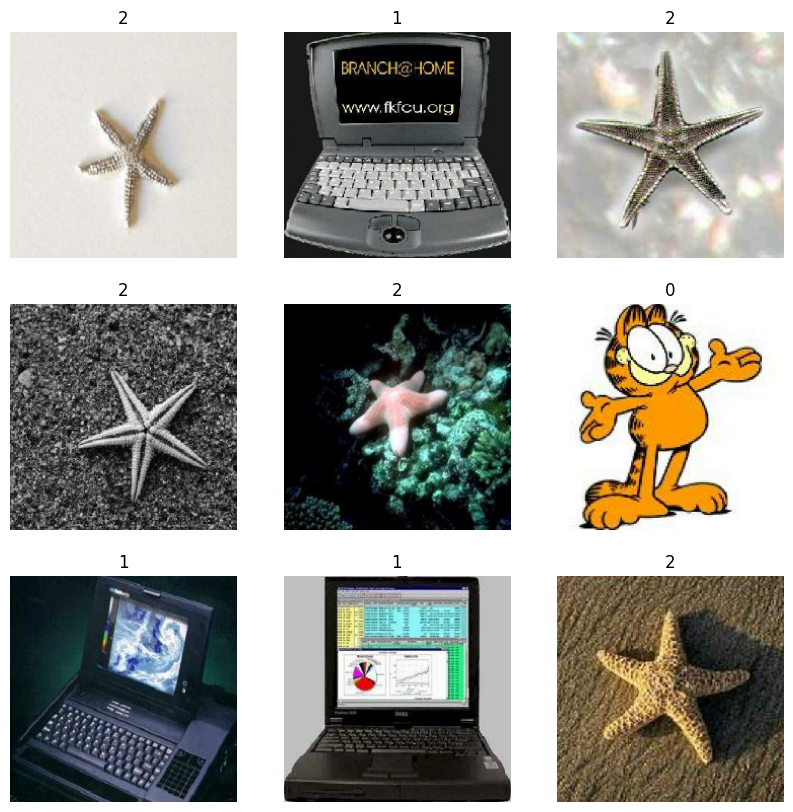

In [81]:
plt.figure(figsize=(10, 10))
# берем один батч
for images, labels in train_ds.take(1):
    # отрисуем 9 картинок из батча
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        # выводим картинку
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        # выключаем оси (чтобы они не отображались)
        plt.axis("off")

Получаем следующее распределение по классам: 
* 0 - garfield 
* 1 - laptop
* 2 - starfish

### Применение аугментации к данным

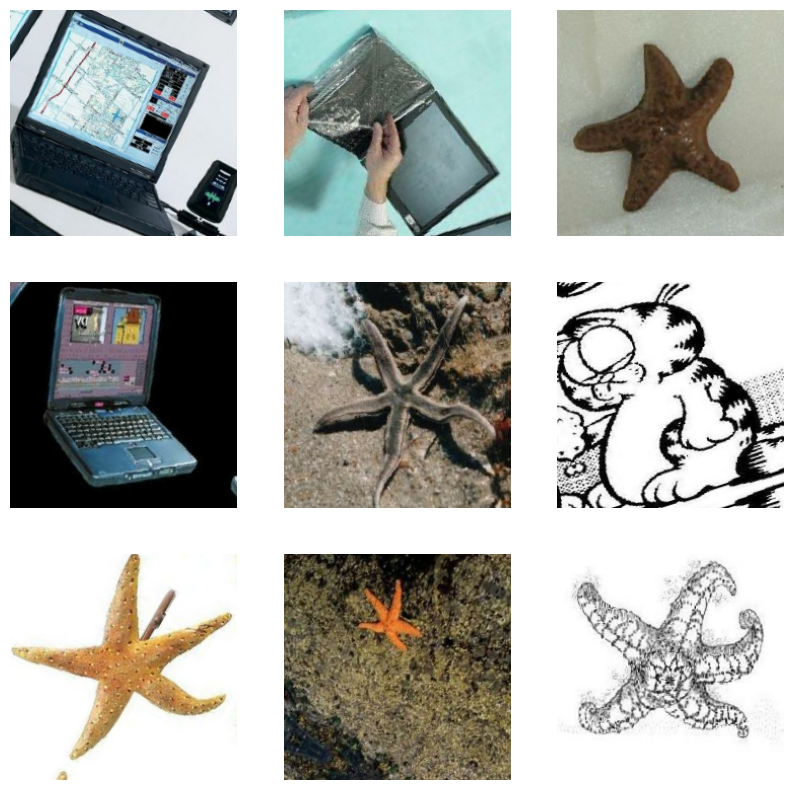

In [82]:
data_augmentation = tf.keras.Sequential(
    [
        RandomFlip("horizontal_and_vertical"),
        RandomRotation(0.1),
    ]
)

plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[i].numpy().astype("uint8"))
        plt.axis("off")

Заметим, что определение морских звезд не зависит от поворота их изображения в любую из сторон. Круто :)

### Transfer learning и Fine-tuning

Загрузим предварительно обученную сеть VGG19 без полносвязных слоев

In [92]:
import tensorflow as tf


vgg = tf.keras.applications.VGG19(weights='imagenet', include_top = False, input_shape=[224, 224, 3])

In [93]:
vgg.summary()

Model: "vgg19"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0     

Теперь полностью опишем все полносвязные слои ручками. Поскольку модель будет использовать предыдущие веса, на данный момент она останется неподготовленной:

In [94]:
for  layer in vgg.layers:
    layer.trainable = False

In [97]:
# Flattened the last layer
x = keras.layers.Rescaling(1.0 / 255)(vgg.output)
x = keras.layers.Flatten()(x)

x = keras.layers.Dense(4096, activation='sigmoid')(x)
x = keras.layers.Dense(2048, activation='sigmoid')(x)
# Created a new layer as output
prediction = keras.layers.Dense(3, activation = 'softmax')(x)

# Join it with the model
model_new = keras.Model(inputs = vgg.input, outputs = prediction)

# Visualize the model again
model_new.summary()

Model: "model_10"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 56, 56, 128)       0  

In [98]:
model_new.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
model_new.fit(train_ds, epochs=5, validation_data=test_ds)

Epoch 1/5


6/6 [==============================] - 18s 3s/step - loss: 5.6952 - accuracy: 0.4561 - val_loss: 0.6353 - val_accuracy: 0.8000
Epoch 2/5
6/6 [==============================] - 23s 4s/step - loss: 0.7738 - accuracy: 0.6608 - val_loss: 0.4551 - val_accuracy: 0.8333
Epoch 3/5
6/6 [==============================] - 20s 3s/step - loss: 0.3075 - accuracy: 0.8480 - val_loss: 0.0851 - val_accuracy: 1.0000
Epoch 4/5
6/6 [==============================] - 21s 4s/step - loss: 0.0720 - accuracy: 0.9825 - val_loss: 0.0760 - val_accuracy: 0.9667
Epoch 5/5
6/6 [==============================] - 22s 4s/step - loss: 0.0319 - accuracy: 0.9942 - val_loss: 0.0482 - val_accuracy: 1.0000


ЕДИНИЦА ТОЧНОСТИ НА ТЕСТОВОЙ ВЫБОРКЕ !!!!!!!!!

1/1 [==============================] - 0s 225ms/step
[[2.4401325e-04 9.9969184e-01 6.4201769e-05]]
Распознанный класс: 1


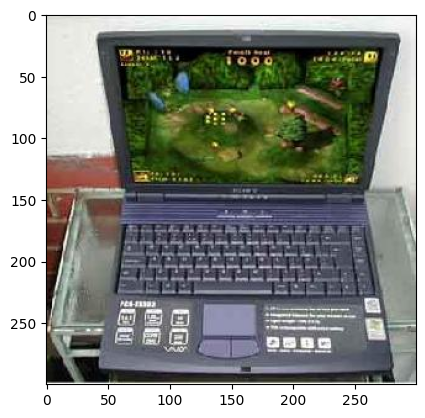

In [99]:
path = "../../../Jupyter Notebook/data/data4/laptop/image_0073.jpg"
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))

Теперь тоже самое, но попроще с предварительно обученной моделью InceptionV3.

In [100]:
base_model = keras.applications.InceptionV3(weights='imagenet', 
                                include_top=False, 
                                input_shape=(224, 224,3))

87910968/87910968 [==============================] - 101s 1us/step


In [102]:
base_model.trainable = False

add_model = keras.Sequential()
add_model.add(base_model)
add_model.add(keras.layers.GlobalAveragePooling2D())
add_model.add(keras.layers.Dropout(0.5))
add_model.add(keras.layers.Dense(3, activation='softmax'))

model = add_model
model.compile(loss='sparse_categorical_crossentropy', 
              optimizer=keras.optimizers.SGD(lr=1e-4, momentum=0.9),
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inception_v3 (Functional)   (None, 5, 5, 2048)        21802784  
                                                                 
 global_average_pooling2d_1  (None, 2048)              0         
  (GlobalAveragePooling2D)                                       
                                                                 
 dropout_5 (Dropout)         (None, 2048)              0         
                                                                 
 dense_23 (Dense)            (None, 3)                 6147      
                                                                 
Total params: 21808931 (83.19 MB)
Trainable params: 6147 (24.01 KB)
Non-trainable params: 21802784 (83.17 MB)
_________________________________________________________________


In [104]:
model.fit(train_ds, epochs=20, validation_data=test_ds)

Epoch 1/20


6/6 [==============================] - 2s 400ms/step - loss: 2055.7454 - accuracy: 0.6199 - val_loss: 626.6141 - val_accuracy: 0.7000
Epoch 2/20
6/6 [==============================] - 2s 406ms/step - loss: 1724.5784 - accuracy: 0.6959 - val_loss: 1549.9484 - val_accuracy: 0.7000
Epoch 3/20
6/6 [==============================] - 3s 428ms/step - loss: 1844.7604 - accuracy: 0.6082 - val_loss: 1056.2719 - val_accuracy: 0.7667
Epoch 4/20
6/6 [==============================] - 3s 437ms/step - loss: 2900.9009 - accuracy: 0.6140 - val_loss: 842.8187 - val_accuracy: 0.7000
Epoch 5/20
6/6 [==============================] - 3s 444ms/step - loss: 1686.2629 - accuracy: 0.6491 - val_loss: 1468.2479 - val_accuracy: 0.6333
Epoch 6/20
6/6 [==============================] - 3s 450ms/step - loss: 1471.2463 - accuracy: 0.7135 - val_loss: 2057.2026 - val_accuracy: 0.7333
Epoch 7/20
6/6 [==============================] - 3s 459ms/step - loss: 2152.2007 - accuracy: 0.6608 - val_loss: 1333.6061 - val_accuracy

1/1 [==============================] - 0s 131ms/step
[[0.9661977  0.00271102 0.03109127]]
Распознанный класс: 0


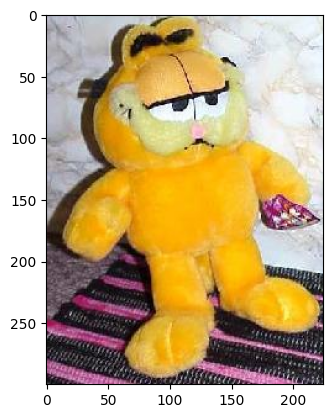

In [106]:
path = "../../../Jupyter Notebook/data/data4/garfield/image_0006.jpg"
img = tf.keras.preprocessing.image.load_img(
    path, target_size=(224, 224)
)
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = tf.expand_dims(img_array, 0)

predictions = model_new.predict(img_array)
print(predictions)
print('Распознанный класс:', np.argmax(predictions))

plt.imshow(Image.open(path))

## Собственная реализация свёрточного слоя (convolution layer)

In [1]:
%run -m Layers
%run -m CNN

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

image_datagen = ImageDataGenerator( rescale=1./255 )

image_generator = image_datagen.flow_from_directory(
    '../../../Jupyter Notebook/data/data3',
    target_size=(400, 400),
    batch_size=100)

Found 2000 images belonging to 2 classes.


In [27]:
# NumPy array
# (num_imges, num_channels, rows, cols)

# Tensor
# (num_imges, rows, cols, num_channels)

X, y = image_generator[0]

X = np.transpose(X, (0, 3, 1, 2))
y = y[:, :, np.newaxis]

X.shape, y.shape

((100, 3, 400, 400), (100, 2, 1))

Epoch 1/5 - loss: 1.3837
Epoch 2/5 - loss: 0.8301
Epoch 3/5 - loss: 0.8053
Epoch 4/5 - loss: 0.7676
Epoch 5/5 - loss: 0.7559


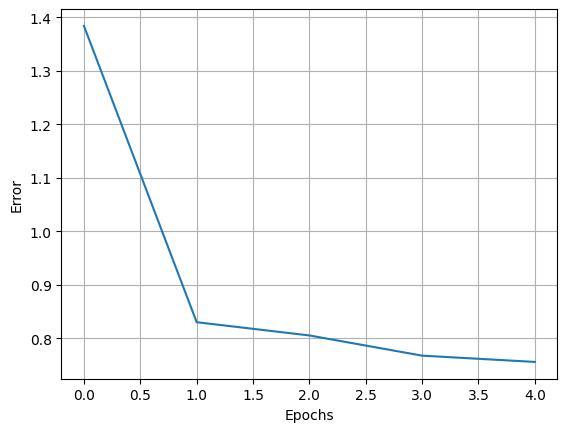

In [31]:
from CNN import CNN
from Layers import Conv2D, Flatten, Dense


network = [
    Conv2D(kernel_size=3, depth=2, activation='sigmoid'),
    Flatten(),
    Dense(100, activation='sigmoid'),
    Dense(2, activation='sigmoid'),
]

cnn = CNN((3, 400, 400), network, 'BinaryCrossEntropy')
cnn.fit(X, y, 5, 0.01)
cnn.error_plot

In [45]:
from sklearn.metrics import accuracy_score

y_true = []
y_predi = []
for xx, yy in zip(X, y):
    y_pred = np.argmax(cnn.predict(xx))
    y_predi.append(y_pred)
    y_true.append(np.argmax(yy))

print('Accuracy:', accuracy_score(y_predi, y_true))

c:\Users\seito\Jupyter Notebook\notebooks\Лабораторная №8\Layers.py:12: RuntimeWarning: overflow encountered in exp
  'sigmoid': (lambda x: 1/(1 + np.exp(-x))),


Accuracy: 0.61
